In [1]:
import re
from datetime import datetime
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')
import string
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix

from sklearn.model_selection import cross_val_score, KFold

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SCYS057\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\SCYS057\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\SCYS057\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
import pickle
import json

In [73]:
stop_words =  pd.read_excel('D:\AIA\POS\MAIA\API_files\stopwords.xlsx')
stop_words = stop_words['stopword'].to_list()

sw_more = nltk.corpus.stopwords.words('english')
stop_words.extend(sw_more)

In [74]:
with open('stop_words.ob', 'wb') as fp:
    pickle.dump(stop_words, fp)

In [17]:
%%time 
raw_data = pd.read_excel('D:\\AIA\\POS\\MAIA\\LiveChat Conversation Data\\User Verified 4 - SessionSplitLogic\\train_set_message_only.xlsx')

Wall time: 236 ms


In [18]:
raw_data

,Date,Text,Session,Abuse
0,2021-09-10 15:35:34.180,new business,72f95523-6ae6-43e5-9bdc-097b4f47d8f1-4,0
1,2021-09-10 15:37:36.401,checking for m2b transfer sum assured,72f95523-6ae6-43e5-9bdc-097b4f47d8f1-4,0
2,2021-09-06 10:20:27.905,check for shield downgrade,72f95523-6ae6-43e5-9bdc-097b4f47d8f1-2,0
3,2021-09-22 12:21:36.570,pos,72f95523-6ae6-43e5-9bdc-097b4f47d8f1-14,0
4,2021-09-22 12:21:52.831,change to monthly how much,72f95523-6ae6-43e5-9bdc-097b4f47d8f1-14,0
...,...,...,...,...
2913,2021-09-24 16:11:36.863,"hi, i need help to unlock my client -my aia sg",00aaee76-12e0-4096-a18c-4f312606d168-1,0
2914,2021-09-24 16:12:08.640,no,00aaee76-12e0-4096-a18c-4f312606d168-1,0
2915,2021-09-08 15:06:08.988,cpf,006da37c-aee6-4119-ab25-1024e60d1e97-2,1
2916,2021-09-19 18:04:21.430,covid,0031d6dc-3a14-4d50-b2b7-828679011b6f-8,1


In [49]:
# Convert data to json format to mimis jason input
js = raw_data.to_json(orient = 'records', date_format='iso')
# jdata = json.loads(js)

In [25]:
def text_cleaning(txt):
    
    text = txt.lower()
    
    text = re.sub(r'[a-z]{1}[0-9]{9}', '', text)
    text = re.sub(r'[a-z]{1}[0-9]{7}[a-z]{1}', 'UniNRIC', text)
    text = re.sub(r'[0-9]{8}', '', text)
    
    text = " ".join([word for word in nltk.word_tokenize(text) if word not in stop_words])
    text = " ".join(word.strip(string.punctuation) for word in text.split())

    emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) # Remove Emoji

    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in nltk.word_tokenize(text)])
    
    return text

In [200]:
# raw_data['text_clean'] = raw_data['Text'].apply(lambda x:text_cleaning(x))

In [53]:
def data_preprocessing(js):

    jdata = json.loads(js)
    df = pd.DataFrame(jdata)
    df['text_clean'] = df['Text'].apply(lambda x:text_cleaning(x))

    df = df.groupby(['Session', 'Abuse'])['text_clean'].apply(lambda x: ','.join(x)).reset_index()
    
    df['WordsAsked'] = df['text_clean'].str.split().str.len()

    
    return df[['Session', 'Abuse', 'WordsAsked']]

In [286]:
# seed_num = 123

# tfidf = TfidfVectorizer(min_df = 0.002,  ngram_range=(1, 2), use_idf = True, sublinear_tf = True, max_df = 0.8)


# features = tfidf.fit_transform(df.text_clean).toarray()
# labels = df.Abuse

In [54]:
%%time
df = data_preprocessing(js)

Wall time: 1.1 s


In [65]:
X, Y = df[df.columns.difference(['Session', 'Abuse'])], df[['Abuse']]

In [66]:
seed = 2
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [67]:
model = XGBClassifier(eval_metric='logloss', random_state=128)
model.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
       gamma=0, gpu_id=-1, importance_type='gain',
       interaction_constraints='', learning_rate=0.300000012,
       max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
       monotone_constraints='()', n_estimators=100, n_jobs=8,
       num_parallel_tree=1, objective='binary:logistic', random_state=128,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
       tree_method='exact', use_label_encoder=True, validate_parameters=1,
       verbosity=None)

In [68]:
y_pred = model.predict(X_test)
# predictions = [round(value) for value in y_pred]

In [216]:
# merged_df = pd.concat([X_test, y_test, pd.DataFrame(predictions)])

In [69]:
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 90.28%


In [70]:
confusion_matrix(y_test,y_pred)
# true positive: 80

array([[ 89,  13],
       [ 15, 171]], dtype=int64)

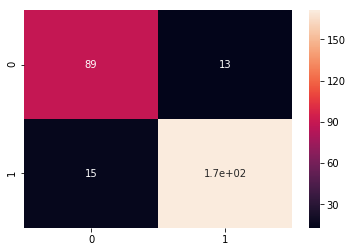

In [71]:
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True)

In [72]:
print(classification_report(y_test,y_pred))
# precision = TP / (TP+FP)
# recall = TP / (TP+FN) = true positive rate


              precision    recall  f1-score   support

           0       0.86      0.87      0.86       102
           1       0.93      0.92      0.92       186

   micro avg       0.90      0.90      0.90       288
   macro avg       0.89      0.90      0.89       288
weighted avg       0.90      0.90      0.90       288



In [221]:
# df_test = df.loc[y_test.index]
# df_test['abuse_predicted'] = y_pred

In [296]:
# df_test.to_csv('df_test.csv', index = False)

In [298]:
# raw_data[raw_data['Session'] == '2cb34a52-c9cb-4cc2-a7dc-e237f8ed53d6-9']

,Date,Text,Session,Abuse,text_clean
1854,2021-09-28 12:44:30.589,nd stay safe@,2cb34a52-c9cb-4cc2-a7dc-e237f8ed53d6-9,1,nd stay safe
1855,2021-09-28 12:44:30.589,nd stay safe@,2cb34a52-c9cb-4cc2-a7dc-e237f8ed53d6-9,1,nd stay safe
1856,2021-09-28 12:44:33.083,!,2cb34a52-c9cb-4cc2-a7dc-e237f8ed53d6-9,1,
1857,2021-09-28 12:44:33.083,!,2cb34a52-c9cb-4cc2-a7dc-e237f8ed53d6-9,1,


In [239]:
filename = 'flask_abuse_detection.sav'
pickle.dump(model, open(filename, 'wb'))